In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
import itertools
import networkx as nx
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [103]:
data_pd = pd.read_csv('data/MergedData.csv', index_col=0)
data_pd = data_pd.loc[data_pd['species'] == 'HomoSapiens']
# data_pd = data_pd.loc[data_pd['database'] == 'tcr_ab_pairs']
data_pd.index = np.arange(data_pd.shape[0])

In [155]:
data_pd.iloc[np.where(data_pd['database'] == 'vdjdb_ab,vdjdb')[0], 0] = 'vdjdb'
data_pd.iloc[np.where(data_pd['database'] == 'tcr_ab_pairs,vdjdb_ab,vdjdb')[0], 0] = 'tcr_ab_pairs,vdjdb'

In [136]:
w = np.where(pd.isnull(data_pd['database']))[0]
data_pd.iloc[w, 0] = 'cd4,cd8'

In [104]:
acdr3 = data_pd['alpha.cdr3'].as_matrix()
bcdr3 = data_pd['beta.cdr3'].as_matrix()
acdr3_length = np.array([len(x) for x in acdr3])
bcdr3_length = np.array([len(x) for x in bcdr3])

In [105]:
auseless_positions = {7: [6],
 8: [2],
 9: [1],
 10: [4, 9],
 11: [2, 4, 10],
 12: [2, 11],
 13: [4],
 14: [4, 13],
 15: [4],
 16: [4, 5, 15],
 17: [4, 6, 16],
 18: [5, 6, 17],
 19: [4]}

buseless_positions = {7: [],
 8: [],
 9: [2],
 10: [4, 9],
 11: [4, 6],
 12: [4, 11],
 13: [4],
 14: [4, 5, 6, 13],
 15: [4, 14],
 16: [4, 15],
 17: [4, 16],
 18: [7, 8, 11, 17],
 19: []}

In [106]:
acdr3f = np.zeros((acdr3.shape[0]), dtype=object)
for i in range(acdr3.shape[0]):
    arr = np.array(list(acdr3[i]))
    if len(arr) in auseless_positions.keys():
        arr[auseless_positions[len(arr)]] = 'X'
    acdr3f[i] = ''.join(arr)
    
bcdr3f = np.zeros((bcdr3.shape[0]), dtype=object)
for i in range(bcdr3.shape[0]):
    arr = np.array(list(bcdr3[i]))
    if len(arr) in buseless_positions.keys():
        arr[buseless_positions[len(arr)]] = 'X'
    bcdr3f[i] = ''.join(arr)

acdr3 = acdr3f
bcdr3 = bcdr3f

In [107]:
def aapClusters(sequences, indexing, mmm=1, delimeter='*'):
    l = len(sequences[0])
    clusters = []
    masks = itertools.combinations(np.arange(l), mmm)
    for mask in masks:
        mask = [-1] + list(mask) + [l]
        masker = lambda x: delimeter.join([x[mask[i] + 1:mask[i + 1]] for i in range(mmm + 1)])
        factor = set([masker(x) for x in sequences])
        c = {m:[] for m in factor}
        for i, x in enumerate(sequences):
            c[masker(x)].append(indexing[i])
        for m in factor:
            if len(c[m]) > 1:
                clusters.append(c[m])
    return clusters

def EdgeListfromClusters(n, clusters):
    edges = set([])
    for cluster in clusters:
        for x, y in itertools.combinations(cluster, 2):
            edges.add((x, y))
    return list(edges)

In [108]:
aedges = []
for l in range(6, 20):
    indexes = np.arange(acdr3.shape[0])[acdr3_length == l]
    a = acdr3[indexes]
    clusters = aapClusters(a, indexes)
    e = EdgeListfromClusters(acdr3.shape[0], clusters)
    aedges += e

bedges = []
for l in range(6, 20):
    indexes = np.arange(bcdr3.shape[0])[bcdr3_length == l]
    b = bcdr3[indexes]
    clusters = aapClusters(b, indexes)
    e = EdgeListfromClusters(bcdr3.shape[0], clusters)
    bedges += e

In [109]:
Agraph = nx.Graph()
Agraph.add_edges_from(aedges)
acomponents = list(nx.connected_components(Agraph))

Bgraph = nx.Graph()
Bgraph.add_edges_from(bedges)
bcomponents = list(nx.connected_components(Bgraph))

In [110]:
acomplength = np.array([len(x) for x in acomponents])
bcomplength = np.array([len(x) for x in bcomponents])

In [111]:
iacomplength = acomplength > 1
ibcomplength = bcomplength > 1

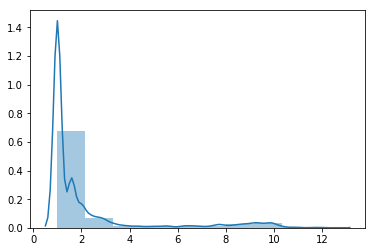

In [13]:
sns.distplot(np.log2(acomplength[iacomplength]), bins=10)

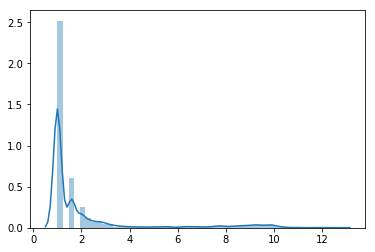

In [15]:
sns.distplot(np.log2(acomplength))

In [112]:
thr = 20

In [113]:
nla, nlb = np.sum(acomplength > thr), np.sum(bcomplength > thr)
nla, nlb

(269, 67)

In [114]:
a_ind = {x:i for i, x in enumerate(np.where(acomplength > thr)[0])}
b_ind = {x:i for i, x in enumerate(np.where(bcomplength > thr)[0])}

In [115]:
a_component = -1 + np.zeros((acdr3.shape[0]), dtype=int)
for i, x in enumerate(acomponents):
    if acomplength[i] > thr:
        a_component[list(x)] = a_ind[i]
b_component = -1 + np.zeros((acdr3.shape[0]), dtype=int)
for i, x in enumerate(bcomponents):
    if bcomplength[i] > thr:
        b_component[list(x)] = b_ind[i]

In [156]:
db = data_pd['database'].values
databases = set()
for x in db:
    for i in x.split(','):
        databases.add(i)
databases = np.array(list(databases))
database2i = {x:i for i, x in enumerate(databases)}

In [157]:
T = np.zeros((databases.shape[0], nla, nlb), dtype=int)
for i in range(data_pd.shape[0]):
    if a_component[i] >= 0 and b_component[i] >= 0:
        for db_ in db[i].split(','):
            T[database2i[db_], a_component[i], b_component[i]] += 1

In [166]:
#databases = databases[:-1]

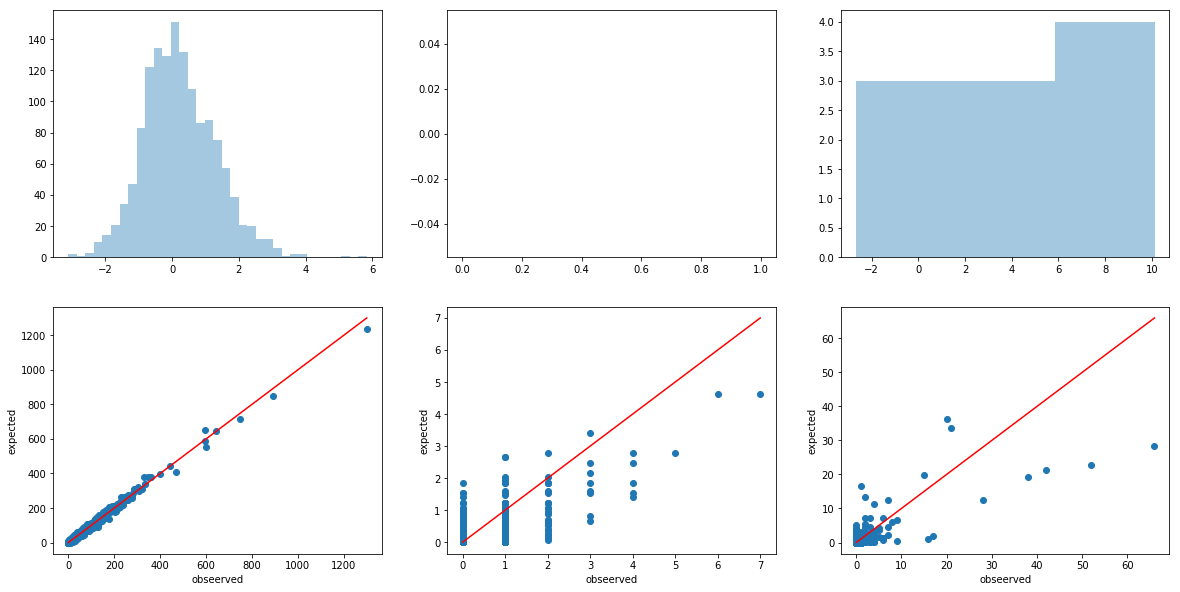

In [168]:
fig, ax = plt.subplots(figsize=(20, 10), nrows=2, ncols=databases.shape[0])
for db_i, db in enumerate(databases):
    t = T[db_i]
    x = np.sum(t, axis=0)
    y = np.sum(t, axis=1)
    e = np.dot(y.reshape(-1, 1), x.reshape(1,-1)) / np.sum(t)
    i = t.reshape(-1) > 10
    z = (t-e) / np.sqrt(1 + e)
    sns.distplot(z.reshape(-1)[i], kde=False, ax=ax[0, db_i])
    ax[1, db_i].set_ylabel('expected')
    ax[1, db_i].set_xlabel('obseerved')
    ax[1, db_i].scatter(t, e)
    ax[1, db_i].plot([0, np.max(t)], [0, np.max(t)], c='red')

In [116]:
t = np.zeros((nla, nlb), dtype=int)
for i in range(acdr3.shape[0]):
    if a_component[i] >= 0 and b_component[i] >= 0:
        t[a_component[i], b_component[i]] += 1

In [117]:
x = np.sum(t, axis=0)
y = np.sum(t, axis=1)
e = np.dot(y.reshape(-1, 1), x.reshape(1,-1)) / np.sum(t)
i = t.reshape(-1) > 10
z = (t-e) / np.sqrt(1 + e)

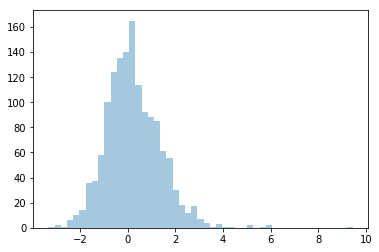

In [118]:
sns.distplot(z.reshape(-1)[i], kde=False)

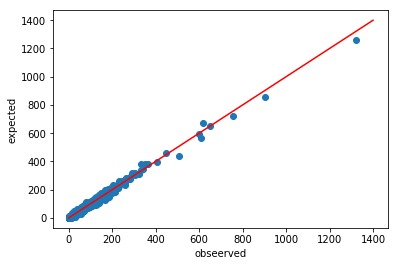

In [119]:
plt.ylabel('expected')
plt.xlabel('obseerved')
plt.scatter(t, e)
plt.plot([0, 1400], [0, 1400], c='red')

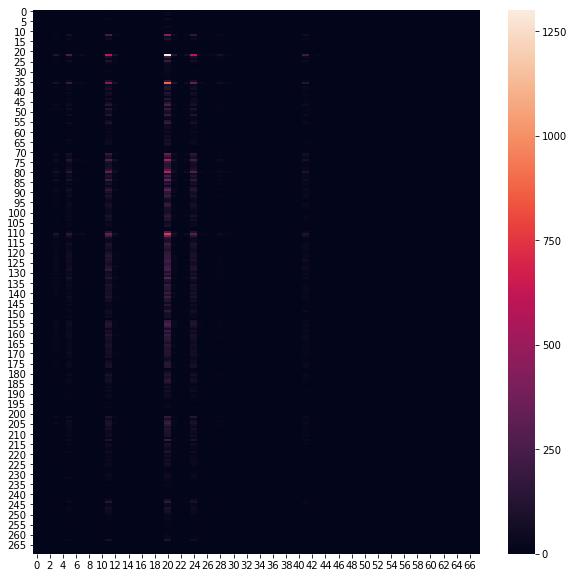

In [102]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(t, ax=ax)

In [8]:
aadj = [[] for i in range(acdr3.shape[0])]
badj = [[] for i in range(acdr3.shape[0])]

for i in aedges:
    aadj[i[0]].append(i[1])
    aadj[i[1]].append(i[0])

for i in bedges:
    badj[i[0]].append(i[1])
    badj[i[1]].append(i[0])

In [9]:
superadj = [list(set(aadj[i]) & set(badj[i]))for i in range(acdr3.shape[0])]

In [10]:
s = 0
for i in superadj:
    s += len(i)
s

11870

In [11]:
len(aedges) * len(bedges) / (acdr3.shape[0] ** 2 // 2)

3266.498227705472

In [12]:
superdeg = np.array([len(x) for x in superadj])
multdeg = np.array([len(aadj[i]) * len(badj[i]) for i in range(acdr3.shape[0])])

In [13]:
max(multdeg), max(superdeg)

(1012860, 9)

In [14]:
aa = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', 'X']
aa2num = {aa[i]:i for i in range(21)}

class PWM:
    def __init__(self, sequences):
        assert len(sequences) > 0
        self.l = len(sequences[0])
        PPM = np.ones((self.l, 21), dtype=float)
        for seq in sequences:
            assert len(seq) == self.l
            for pos in range(self.l):
                PPM[pos, aa2num[seq[pos]]] += 1
        self.PWM = np.log2(PPM)
    
    def Score(self, seq):
        assert self.l == len(seq)
        return sum([self.PWM[pos, aa2num[seq[pos]]] for pos in range(self.l)])

In [357]:
ind = np.where(z > 50)[0]
ind

18048

In [358]:
pwm_a = PWM([acdr3[ind]])
pwm_b = PWM([bcdr3[ind]])

In [359]:
indexes = [(len(acdr3[j]) == len(acdr3[ind])) & 
           (len(bcdr3[j]) == len(bcdr3[ind])) for j in range(acdr3.shape[0])]
acdr3i = acdr3[indexes]
bcdr3i = bcdr3[indexes]

In [360]:
ascores = np.array([pwm_a.Score(a) for a in acdr3i])
bscores = np.array([pwm_b.Score(b) for b in bcdr3i])

ascores = ascores - ascores[indi]
bscores = bscores - bscores[indi]

In [361]:
indi = list(set(np.where(acdr3i==acdr3[i])[0]) & set(np.where(bcdr3i==bcdr3[i])[0]))[0]

In [363]:
athr, bthr = -3, -3
indx = np.array(list(set(np.where(ascores > athr)[0]) & set(np.where(bscores > bthr)[0])))
score = (indx.shape[0] * acdr3i.shape[0]) / (np.sum(ascores > athr) * np.sum(bscores > bthr))
np.sum(ascores > athr), np.sum(bscores > bthr), indx.shape[0], acdr3i.shape[0], score

(67, 66, 11, 1564, 3.8905472636815919)

In [327]:
W = data_pd.loc[indx]

In [235]:
memmory_a_2 = np.copy(indexes_list[np.where(ascores > -3)[0]])
memmory_b_2 = np.copy(indexes_list[np.where(bscores > -3)[0]])

In [306]:
pwm_a = PWM(acdr3i[indx])
pwm_b = PWM(bcdr3i[indx])

In [337]:
acdr3[indexes_list[indx]], bcdr3[indexes_list[indx]]

(array(['CVXPXGQNFVX', 'CVXVXGQNFVX', 'CVXLXGQNFVX', 'CVXSXGQNFVX',
        'CVXSXGQNFVX', 'CVXVXGQNFVX', 'CVXNXGQNFVX', 'CVXLXGQNFVX',
        'CVXGXGQNFVX'], dtype=object),
 array(['CASSXDGNYGYTF', 'CASSXDGNYGYTF', 'CASSXGPNYGYTF', 'CASSXDGNYGYTF',
        'CASSXDPNYGYTF', 'CASSXDPNYGYTF', 'CASSXDGNYGYTF', 'CASSXDGNYGYTF',
        'CASSXDPNYGYTF'], dtype=object))

In [231]:
indexes_list = np.where(indexes)[0]

array([    57,    317,    376, ..., 169308, 169368, 169521])

In [225]:
ind2full = {x:i for i, x in enumerate(np.where(indexes)[0])}

In [228]:
ind2full[ind]

188

In [290]:
memmory_1 = np.array(list(set(memmory_a_1) & set(memmory_b_1)))
memmory_1

array([ 18048,  89920, 118403, 155961,  35720,  64398,  26329,  35001,
       157116,  94718])

In [329]:
Q = data_pd.loc[memmory_1]
Q

,database,species,sample,epitope,antigen,tissue,cell_subset,alpha.v,alpha.j,alpha.cdr3,beta.v,beta.d,beta.j,beta.cdr3
18048,tcr_ab_pairs,HomoSapiens,3,NaN,NaN,NaN,NaN,TRAV12-1,TRAJ26,CVVLYGQNFVF,"TRBV5-4,TRBV5-8",NaN,TRBJ1-2,CASSPDGNYGYTF
89920,tcr_ab_pairs,HomoSapiens,3,NaN,NaN,NaN,NaN,TRAV12-1,TRAJ26,CVGVYGQNFVF,TRBV9,NaN,TRBJ1-2,CASSEDPNYGYTF
118403,tcr_ab_pairs,HomoSapiens,3,NaN,NaN,NaN,NaN,TRAV12-1,TRAJ26,CVGNYGQNFVF,TRBV4-1,NaN,TRBJ1-2,CASSQDGNYGYTF
155961,tcr_ab_pairs,HomoSapiens,3,NaN,NaN,NaN,NaN,TRAV12-1,TRAJ26,CVVSYGQNFVF,TRBV15,NaN,TRBJ1-2,CATSRDGNYGYTF
35720,tcr_ab_pairs,HomoSapiens,3,NaN,NaN,NaN,NaN,"TRAV12-1,TRAV12-3",TRAJ26,CVAPYGQNFVF,TRBV9,NaN,TRBJ1-2,CASSVDGNYGYTF
64398,tcr_ab_pairs,HomoSapiens,2,NaN,NaN,NaN,NaN,TRAV12-1,TRAJ26,CVVGYGQNFVF,TRBV9,NaN,TRBJ1-2,CASSVDPNYGYTF
26329,tcr_ab_pairs,HomoSapiens,"3,2",NaN,NaN,NaN,NaN,TRAV12-1,TRAJ26,CVSSYGQNFVF,TRBV9,NaN,TRBJ1-2,CASSVDPNYGYTF
35001,tcr_ab_pairs,HomoSapiens,"3,2",NaN,NaN,NaN,NaN,TRAV12-3,TRAJ26,CVEVYGQNFVF,"TRBV4-1,TRBV4-3,TRBV4-2,TRBV4-1,TRBV4-3",NaN,TRBJ1-2,CASSQDGNYGYTF
157116,tcr_ab_pairs,HomoSapiens,3,NaN,NaN,NaN,NaN,TRAV12-1,TRAJ26,CVVSYGQNFVF,"TRBV4-1,TRBV4-3",NaN,TRBJ1-2,CASSQDGNYGYTF
94718,tcr_ab_pairs,HomoSapiens,3,NaN,NaN,NaN,NaN,TRAV12-1,TRAJ26,CVVLYGQNFVF,"TRBV5-4,TRBV5-8","TRBD2,TRBD1",TRBJ1-2,CASSQGPNYGYTF


In [364]:
alpha = data_pd['alpha.cdr3']
beta = data_pd['beta.cdr3']

indexes2 = [len(a) == pwm_a.l and len(b) == pwm_b.l for a, b in zip(alpha, beta)]

alpha = alpha[indexes2]
beta = beta[indexes2]

In [365]:
ascores = np.array([pwm_a.Score(a) for a in alpha])
bscores = np.array([pwm_b.Score(b) for b in beta])

ascores = ascores - max(ascores)
bscores = bscores - max(bscores)

athr, bthr = -2, -4
indx = np.array(list(set(np.where(ascores > athr)[0]) & set(np.where(bscores > bthr)[0])))
score = (indx.shape[0] * acdr3i.shape[0]) / (np.sum(ascores > athr) * np.sum(bscores > bthr))
np.sum(ascores > athr), np.sum(bscores > bthr), indx.shape[0], acdr3i.shape[0], score

(24, 147, 13, 1564, 5.7630385487528342)

In [366]:
D = data_pd.loc[indexes2]
D.index = np.arange(D.shape[0])
D.loc[indx]

,database,species,sample,epitope,antigen,tissue,cell_subset,alpha.v,alpha.j,alpha.cdr3,beta.v,beta.d,beta.j,beta.cdr3
192,tcr_ab_pairs,HomoSapiens,3,NaN,NaN,NaN,NaN,TRAV12-1,TRAJ26,CVVLYGQNFVF,"TRBV5-4,TRBV5-8",NaN,TRBJ1-2,CASSPDGNYGYTF
350,tcr_ab_pairs,HomoSapiens,"3,2",NaN,NaN,NaN,NaN,TRAV12-3,TRAJ26,CVEVYGQNFVF,"TRBV4-1,TRBV4-3,TRBV4-2,TRBV4-1,TRBV4-3",NaN,TRBJ1-2,CASSQDGNYGYTF
166,tcr_ab_pairs,HomoSapiens,3,NaN,NaN,NaN,NaN,TRAV12-1,TRAJ26,CVALYGQNFVF,"TRBV11-3,TRBV11-1,TRBV11-2",TRBD1,TRBJ1-2,CASSLGQGYGYTF
1126,tcr_ab_pairs,HomoSapiens,3,NaN,NaN,NaN,NaN,TRAV12-1,TRAJ26,CVGNYGQNFVF,TRBV4-1,NaN,TRBJ1-2,CASSQDGNYGYTF
359,tcr_ab_pairs,HomoSapiens,3,NaN,NaN,NaN,NaN,"TRAV12-1,TRAV12-3",TRAJ26,CVAPYGQNFVF,TRBV9,NaN,TRBJ1-2,CASSVDGNYGYTF
1510,tcr_ab_pairs,HomoSapiens,3,NaN,NaN,NaN,NaN,TRAV12-1,TRAJ26,CVVSYGQNFVF,TRBV15,NaN,TRBJ1-2,CATSRDGNYGYTF
989,tcr_ab_pairs,HomoSapiens,3,NaN,NaN,NaN,NaN,TRAV12-1,TRAJ26,CVATYGQNFVF,TRBV9,TRBD1,TRBJ1-2,CASSVEGALGYTF
1520,tcr_ab_pairs,HomoSapiens,3,NaN,NaN,NaN,NaN,TRAV12-1,TRAJ26,CVVSYGQNFVF,"TRBV4-1,TRBV4-3",NaN,TRBJ1-2,CASSQDGNYGYTF
888,tcr_ab_pairs,HomoSapiens,3,NaN,NaN,NaN,NaN,TRAV12-1,TRAJ26,CVVLYGQNFVF,"TRBV5-4,TRBV5-8","TRBD2,TRBD1",TRBJ1-2,CASSQGPNYGYTF
600,tcr_ab_pairs,HomoSapiens,2,NaN,NaN,NaN,NaN,TRAV12-1,TRAJ26,CVVGYGQNFVF,TRBV9,NaN,TRBJ1-2,CASSVDPNYGYTF


In [334]:
cdr3s = data_pd['alpha.cdr3'] + '_' + data_pd['beta.cdr3']

In [ ]:
cdr32i = {x:i for i, x in enumerate(cdr3s)}
IW = 